In [1]:
# %matplotlib widget
%matplotlib notebook

In [3]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from os.path import join, basename
from uavsar_pytools.convert.tiff_conversion import read_annotation
from copy import deepcopy

In [ ]:
in_dir = '/Users/zachkeskinen/Documents/uavsar_snow/polsar_imgs/uticam_21003_21004_002_210120_L090_CX_01_grd'

In [ ]:
ann_fp = glob(join(in_dir, '*.ann'))[0]
desc = read_annotation(ann_fp)

In [5]:
nrows = desc['grd_pwr.set_rows']['value']
ncols = desc['grd_pwr.set_cols']['value']
fps = glob(join(in_dir, '*.grd'))
pol = {}
for f in fps:
    name = basename(f).split('_')[-3][4:]
    if name == 'HVVV' or name == 'HHHV' or name == 'HHVV':
        arr = np.fromfile(f, dtype = np.complex64).reshape(nrows, ncols)
    else:
        arr = np.fromfile(f, dtype = np.float32).reshape(nrows, ncols)
    arr[arr == 0] = np.nan
    pol[name] = arr

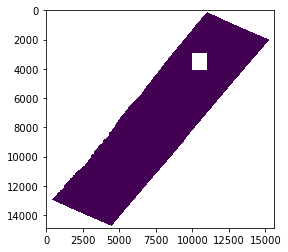

In [6]:
x_min, x_max = 3000,4000
y_min, y_max = 10000,11000
sub_VVVV = pol['VVVV'][x_min:x_max,y_min:y_max]
sub_HHHH = pol['HHHH'][x_min:x_max,y_min:y_max]
sub_HHVV = pol['HHVV'][x_min:x_max,y_min:y_max]
sub_HVHV = pol['HVHV'][x_min:x_max,y_min:y_max]
sub_HVVV = pol['HVVV'][x_min:x_max,y_min:y_max]
sub_HHHV = pol['HHHV'][x_min:x_max,y_min:y_max]
t = deepcopy(pol['VVVV'])
t[x_min:x_max,y_min:y_max] = np.nan
plt.imshow(t)

In [28]:
def calc_C3(pHHHH, pHHHV, pHVHV, pHVVV, pHHVV, pVVVV):
    c11 = pHHHH
    c12 = np.sqrt(2)*pHHHV
    c13 = pHHVV
    c21 = np.sqrt(2)*np.conjugate(pHHHV)
    c22 = 2*pHVHV
    c23 = np.sqrt(2)*pHVVV
    c31 = np.conjugate(pHHVV)
    c32 = np.sqrt(2)*np.conjugate(pHVVV)
    c33 = pVVVV
    c3 = np.array([[c11,c12,c13],
    [c21,c22,c23],
    [c31,c32,c33]])
    return c3

In [93]:
def C3_to_T3(c):
    t11 = 0.5*(c[0,0]+2*c[0,2].real + c[2,2])
    t21 = 0.5*(c[0,0]-c[2,2]) + (-c[0,2].imag)*1j
    t31 = (c[0,1].real + c[1,2].real + c[0,1].imag - c[1,2].imag)/np.sqrt(2)*1j
    t22 = 0.5*(c[0,0] - 2 * c[0,2].real + c[2,2])
    t32 = (c[0,1].real - c[1,2].real + c[0,1].imag + c[1,2].imag)/np.sqrt(2)*1j
    t33 = c[1,1]
    t12 = np.conjugate(t21)
    t13 = np.conjugate(t31)
    t23 = np.conjugate(t32)
    T3 = np.array([[t11,t12,t13],
                    [t21,t22,t23],
                    [t31,t32,t33]])
    return T3

In [96]:
T3_to_alpha1(C3_to_T3(c3))

8.749070884297518

In [94]:
def T3_to_alpha1(T3):
    values, vectors = np.linalg.eigh(T3)
    alpha_1 = np.rad2deg(np.arccos(-vectors[0, 2]).real)
    return alpha_1

In [63]:
def T3_to_mean_alpha(T3):
    values, vectors = np.linalg.eigh(T3)
    alphas = np.zeros(3)
    for i in range(3):
        alphas[i] = np.rad2deg(np.arccos(-vectors[0, i]).real)
    return np.nanmean(alphas)

In [97]:
res = np.empty_like(sub_HHHH)*np.nan
for row in range(sub_HHHH.shape[0]):
    for col in range(sub_HHHH.shape[1]):
        if not np.isnan(sub_HHHH[row,col]):
            c3 = calc_C3(sub_HHHH[row,col], sub_HHHV[row,col], sub_HVHV[row,col],sub_HVVV[row,col], sub_HHVV[row,col], sub_VVVV[row,col])
            t3 = C3_to_T3(c3)
            alpha_1 = T3_to_mean_alpha(t3)
            res[row, col] = alpha_1

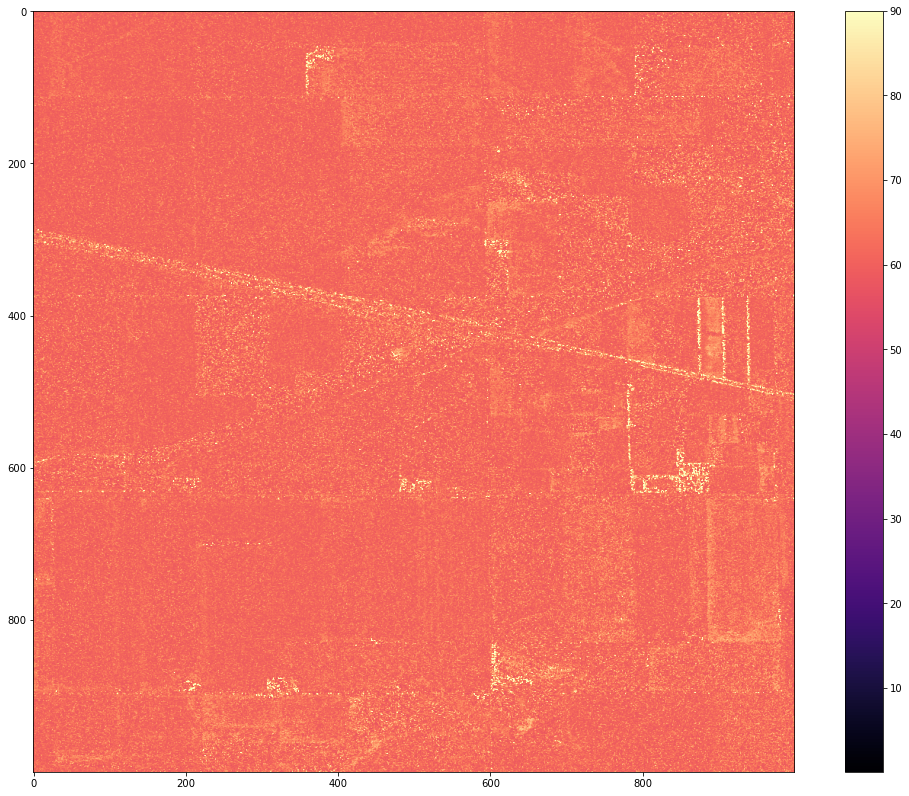

In [98]:
plt.subplots(figsize = (18,14))
plt.imshow(res, vmin = 0.08, vmax = 90, cmap = 'magma')
plt.colorbar()

In [106]:
import math
def calc_H(T3):
    values, _ = np.linalg.eigh(T3)
    weighted = values/np.sum(values)
    h = 0
    for i in range(3):
        h +=  weighted[i] * math.log(weighted[i], 3)
    return -h

In [107]:
res = np.empty_like(sub_HHHH)*np.nan
for row in range(sub_HHHH.shape[0]):
    for col in range(sub_HHHH.shape[1]):
        if not np.isnan(sub_HHHH[row,col]):
            c3 = calc_C3(sub_HHHH[row,col], sub_HHHV[row,col], sub_HVHV[row,col],sub_HVVV[row,col], sub_HHVV[row,col], sub_VVVV[row,col])
            t3 = C3_to_T3(c3)
            try:
                H = calc_H(t3)
            except ValueError:
                H = np.nan
            res[row, col] = H

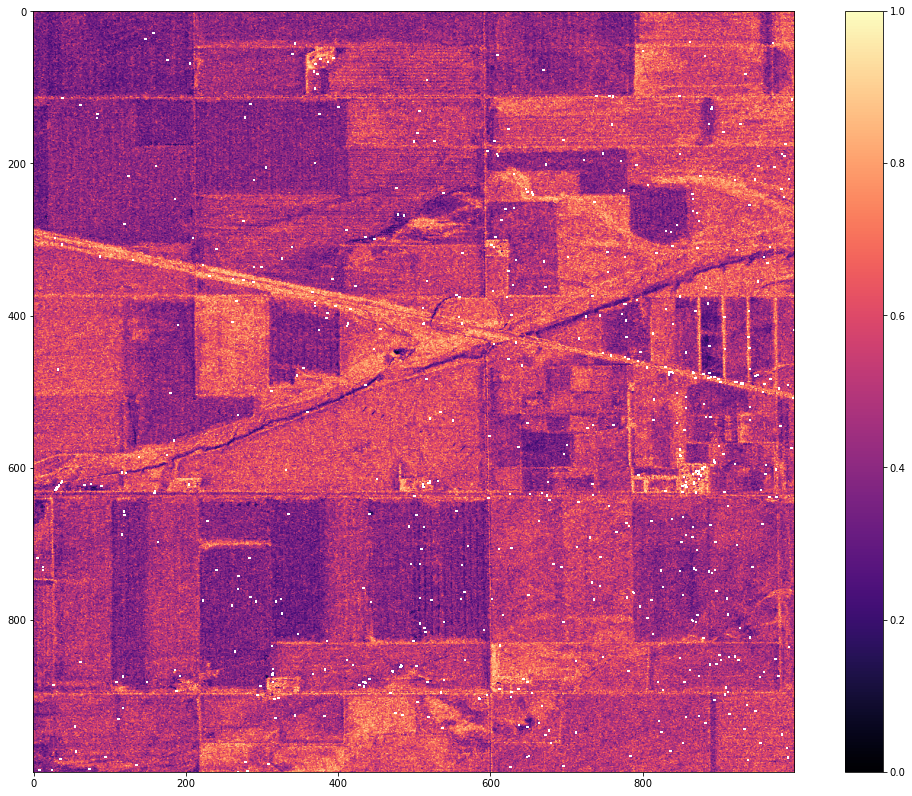

In [109]:
plt.subplots(figsize = (18,14))
plt.imshow(res, vmin = 0, vmax = 1, cmap = 'magma')
plt.colorbar()

In [115]:
def calc_A(T3):
    values, _ = np.linalg.eigh(T3)
    A = (values[1] - values[0])/ (values[1] + values[0])
    return A

In [116]:
res = np.empty_like(sub_HHHH)*np.nan
for row in range(sub_HHHH.shape[0]):
    for col in range(sub_HHHH.shape[1]):
        if not np.isnan(sub_HHHH[row,col]):
            c3 = calc_C3(sub_HHHH[row,col], sub_HHHV[row,col], sub_HVHV[row,col],sub_HVVV[row,col], sub_HHVV[row,col], sub_VVVV[row,col])
            t3 = C3_to_T3(c3)
            try:
                A = calc_A(t3)
            except ValueError:
                A = np.nan
            res[row, col] = A

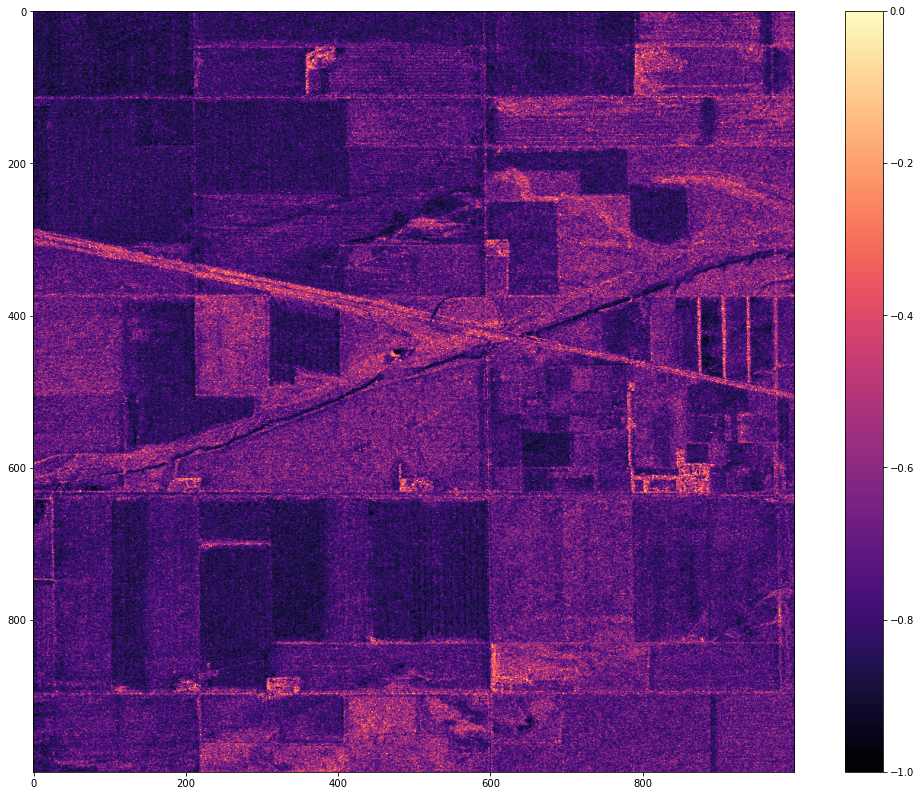

In [ ]:
plt.subplots(figsize = (18,14))
plt.imshow(res, vmin = 0, vmax = 1, cmap = 'magma')
plt.colorbar()